In [9]:
#In this exercise we have chosen the first use case which is "Predict the stock market price for Tesla. 
"""
We decided to use Regression Algorithm since it`s suitable for predictions of continious values such us price, age, weather, traffic etc. 
based on earlier results or measurements. On the other hand the classification algorithm is more suitable to classify or distict values as 
True or False, White or Black, Real or Fake and so on.

We used an LSTM regression algorithm because it is widely used to predict stock prices and forecasting. This algorithm
is really advanced, and we found it quite challenging to use, but was extemly educational to work with. We chose this 
algorithm because we wanted to learn as much as possible for this experience.
"""

'\nWe decided to use Regression Algorithm since it`s suitable for predictions of continious values such us price, age, weather, traffic etc. \nbased on earlier results or measurements. On the other hand the classification algorithm is more suitable to classify or distict values as \nTrue or False, White or Black, Real or Fake and so on. \n'

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [40]:
# This function will take in string inn the from YYYY-MM-DD and
# return datetime datatype.
def str_to_dt(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [41]:
# This function takes inn the dataframe, first date you want to work with from
# the dataframe (note: this has to be 3 days after the first date in the dataframe),
# the last date and an integer n. The function split the dataframe in to three parts
# the first part is the dates, the last part is the target output, the middel part
# is split into three part and are the three previous days of the target output, this
# will be the input of the AI model
def df_to_win_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_dt(first_date_str)
    last_date  = str_to_dt(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df


In [42]:
# This fuction just split the windowed dataframe into the three parts we want.
def win_df_to_date_X_y(win_df):
    df_as_np = win_df.to_numpy()
    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


In [52]:
df = pd.read_csv("https://raw.githubusercontent.com/komandoyoko/DAVE3625---1/main/oblig2/TSLA.csv")

df = df[['Date', 'Close']]

df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3354,2023-10-25,212.419998
3355,2023-10-26,205.759995
3356,2023-10-27,207.300003
3357,2023-10-30,197.360001


In [53]:
df['Date'] = df['Date'].apply(str_to_dt)

df.index = df.pop('Date')

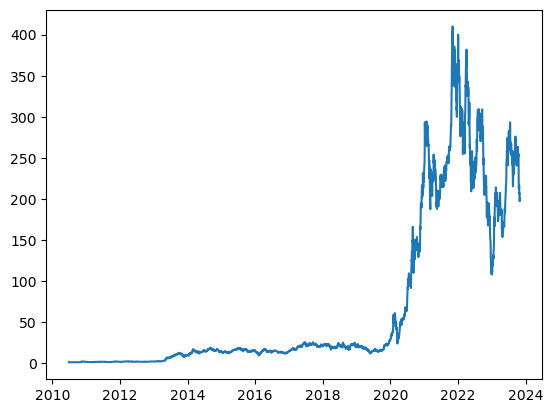

In [54]:
plt.plot(df.index, df['Close'])

In [55]:
df

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2023-10-25,212.419998
2023-10-26,205.759995
2023-10-27,207.300003


In [56]:
df = df_to_win_df(df, "2010-10-27", "2023-10-20", n=3)

In [57]:
df

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-10-27,1.381333,1.390000,1.424000,1.400000
1,2010-10-28,1.390000,1.424000,1.400000,1.412667
2,2010-10-29,1.424000,1.400000,1.412667,1.456000
3,2010-11-01,1.400000,1.412667,1.456000,1.427333
4,2010-11-02,1.412667,1.456000,1.427333,1.416667
...,...,...,...,...,...
3263,2023-10-16,262.989990,258.869995,251.119995,253.919998
3264,2023-10-17,258.869995,251.119995,253.919998,254.850006
3265,2023-10-18,251.119995,253.919998,254.850006,242.679993
3266,2023-10-19,253.919998,254.850006,242.679993,220.110001


In [58]:
dates, X, y = win_df_to_date_X_y(df)

dates.shape, X.shape, y.shape

((3268,), (3268, 3, 1), (3268,))

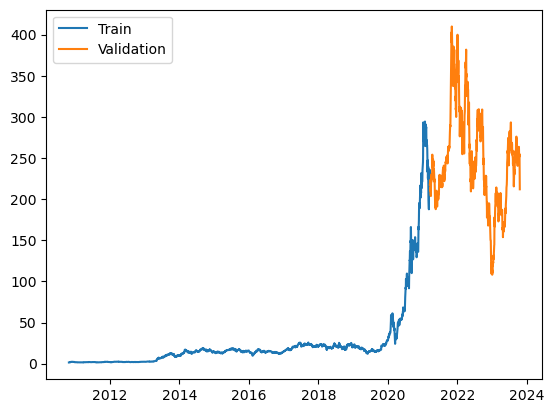

In [66]:
q_80 = int(len(dates) * .8)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Test']) # to se what parts that have been divided into train and test parts

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
82/82 [==============================] - 4s 5ms/step - loss: 2372.6152 - mean_absolute_error: 19.8102
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 1049.6769 - mean_absolute_error: 7.9380
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 152.4560 - mean_absolute_error: 2.8303
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 25.1022 - mean_absolute_error: 1.5108
Epoch 5/100
82/82 [==============================] - 0s 5ms/step - loss: 14.7123 - mean_absolute_error: 1.3110
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 11.9620 - mean_absolute_error: 1.1734
Epoch 7/100
82/82 [==============================] - 0s 5ms/step - loss: 10.0045 - mean_absolute_error: 1.1639
Epoch 8/100
82/82 [==============================] - 0s 5ms/step - loss: 10.3373 - mean_absolute_error: 1.1437
Epoch 9/100
82/82 [==============================] - 0s 5ms/step - loss: 9.7016 - mean_absolute_error: 1.0

In [ ]:
"""
From the mean absolute error on the Epoch's we can see that we don't need to train the model 100 times,
because it will center around the same number. 
"""

82/82 [==============================] - 1s 2ms/step


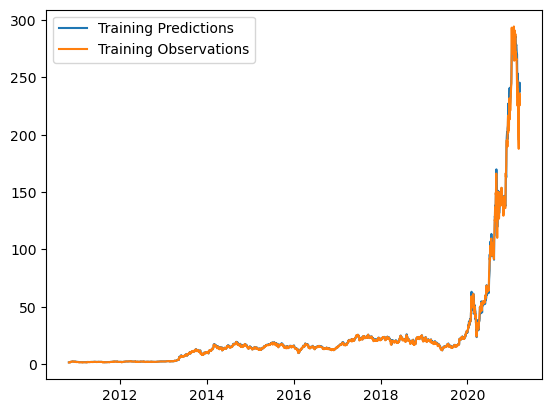

In [68]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# Here can we see the predictions made after training the AI

21/21 [==============================] - 0s 2ms/step


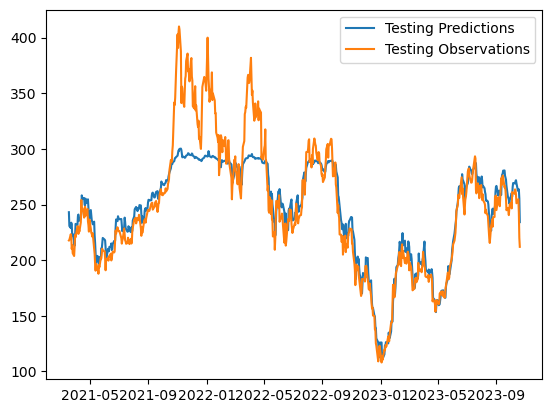

In [69]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# Here we can see the testing prediction compered to observations

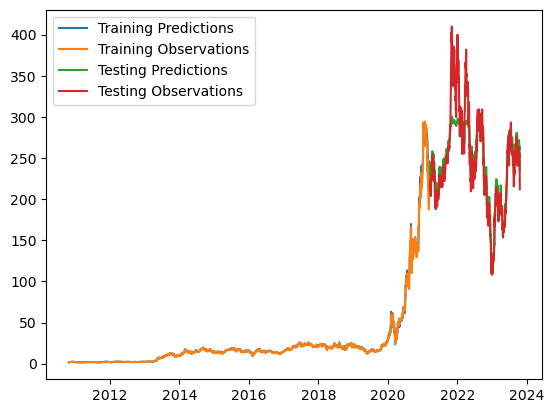

In [70]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Here we see them together

In [71]:
prediction = model.predict(X).flatten() # All predictions

103/103 [==============================] - 0s 2ms/step


In [ ]:
"""
The code block below finds the date in our data set and print out the predicted price of stock
and precentage score of that prediction, we also added the actual price of the stock.
"""

In [72]:
date_in = str_to_dt(input('Type date inn form YYYY-MM-DD(2023-07-18):'))

index = 0

for i in range(len(dates)):
    if date_in==dates[i]:
        index=i
        
        
pred_price = prediction[index] # Predicted price
actu_price = y[index]           # Actual price

per_score = (pred_price/actu_price)*100

if pred_price>actu_price:
    per_score = 200-per_score

    
    
print('Predicted price of stock:', pred_price, 'USD')
print('Actual price of stock:', actu_price, 'USD')
print('Predicted percentage score:', per_score, '%')


Type date inn form YYYY-MM-DD(2023-07-18):2023-07-18
Predicted price of stock: 286.18768 USD
Actual price of stock: 293.34 USD
Predicted percentage score: 97.56176471710205 %


In [ ]:
"""
We tested this AI modell on a smaler dataset also, we removed some of the data from early stock prices before it went up
and the model maneged to get more accurate predictions, because the early data has more off a constant variation the model
struggle to predict huge increases in stock prices, but if we remove data up to 2021 and train and test on that dataset 
the AI will be able to predict huge jump inn stock prices more accuratly. 
"""